# Lumo Run - Deep FFCN and CNN

#### Where is this script being run

In [1]:
machine_to_run_script = 'local' # 'Sherlock', 'local'

# Load dependencies

In [2]:
print('Script is starting!') # these are used for Sherlock to check what is causing the hiccup

import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Input, Lambda, Merge
from keras.layers.normalization import BatchNormalization 
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras import regularizers 
from keras import optimizers
from sklearn.model_selection import GridSearchCV 
from keras.wrappers.scikit_learn import KerasClassifier

print('Successfully loaded keras!')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from datetime import datetime
from dateutil import tz
from IPython import embed
import time
from time import strftime, gmtime
import socket
import pickle
import os.path
#import dill #can't find dill
import itertools

from pathlib import Path
from sklearn.metrics import confusion_matrix 

# from SpeedPrediction_Helper import *

np.random.seed(7) # Set seed for reproducibility

Script is starting!


C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Successfully loaded keras!


#### Set Hyperparameters

In [49]:
# Data Setup

num_channels = 6 # number of time-series channels of data (i.e. 7 kinematic features) #NOTE: Change to 6 by removing Pelvic Tilt (recommended by Lumo)
num_anthropometrics = 4 # number of user anthropometric data elements
input_window_size = 26 # number of timestamps used in the input for prediction (i.e. the input window)
label_window_size = 20 # number of timestamps used to label the speed we will be predicting
speed_minimum = 1.5 # minimum running speed necessary for a training example to be formed
speed_bucket_size = 'none_use_regression' # how to round the data for classification task. Consider '0.5', '0.1', and 'none_use_regression'

previous_model_weights_to_load = "" # If non-empty, load weights from a previous model (note: architectures must be identical)
model_architecture = 'CNN' # 'FCN', 'CNN'
data_input_table_structure = 'Raw_Timeseries' # 'Vectorized_By_Row' 'Raw_Timeseries'
if machine_to_run_script == 'local':
    folder_head_loc = '../';
    folder_data_loc = 'C:/Users/adam/Documents/Lumo/Lumo Data/'
elif machine_to_run_script == 'Sherlock':
    folder_head_loc = '/home/users/agotlin/lumo/'
    folder_data_loc = '/home/users/agotlin/SherlockDataFiles/'
myFileName = 'TimeSeries_InputwNullConcat_100runs'
myFileLocation = folder_data_loc + myFileName + '.csv'
    # Other data files/foldgers to potentially use:
    # 'TimeSeries_InputVector_100runs'   |   'TimeSeries_InputVector_15runs'
    # 'TimeSeries_InputRaw_1000Runs'  |  'TimeSeries_InputRaw_1000Runs_QuarterSample'  |  'TimeSeries_InputRaw_1000Runs_Top10kRowsSample'
    # 'TimeSeries_InputwNullConcat_100runs'  |  'TimeSeries_InputwNullConcat_2000runs'  |  'TimeSeries_InputwNullConcat_5000runs'
    
# Training strategy
batch_size_all = [64] # we used 50 for CNN, 128 for FCN
learning_rate_all = [0.0001,0.001] # we used 0.001 for FCN, 0.0001 for CNN
optimizer_type_all = ['adam'] # options are: "adam" , "rmsprop", "gradient" # adam for FCN, gradient for CNN
loss_function_all = ['mae'] # Other options (from keras defaults or custom) include: 'categorical_crossentropy' ,'mse', 'mae', 'class_mse', 'class_mae'    
training_epochs_all = [10]
    
# Fully Connected Architecture

num_hidden_units_fc_layers = [256, 256, 256, 128, 128, 128]
hidden_units_strategy = ''.join(str(num) + "_" for num in num_hidden_units_fc_layers) # document strategy 
num_hidden_fc_layers = len(num_hidden_units_fc_layers) # document strategy
activations_fc_layers = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu']
activations_strategy = ''.join(str(num) + "_" for num in activations_fc_layers) # document strategy
dropout_rate_fc_layers = [1.0, 1.0, 1.0, 0.8, 0.8, 0.8]
dropout_rates = ''.join(str(num) + "_" for num in dropout_rate_fc_layers) # document strategy

# Convolutional Architecture
    
sample_stride = input_window_size/2 # how many timestamps to shift over between each unique training example # 18, input_window_size/2
num_filters = 40 # number of filters in Conv2D layer (aka depth) # we used 40, ex; used 128
kernel_size = 3 # kernal size of the Conv2D layer # we use 6, example used 2, I would guess closer to 3
activation_conv_layer = "relu" # options are "relu" , "tanh" and "sigmoid" - used for depthwise_conv
max_pool_kernel_size = 3 # max pooling window size# we use 6, example used 2, I don't agre with 6
conv_layer_dropout = 0.2 # dropout ratio for dropout layer # we don't use in our model

num_hidden_units_fc_layers_CNN = [128, 128, 128, 64, 64, 64]
hidden_units_strategy_CNN = ''.join(str(num) + "_" for num in num_hidden_units_fc_layers_CNN) # document strategy 
num_hidden_fc_layers_CNN = len(num_hidden_units_fc_layers_CNN) # document strategy
activations_fc_layers_CNN = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu']
activations_strategy_CNN = ''.join(str(num) + "_" for num in activations_fc_layers_CNN) # document strategy
dropout_rate_fc_layers_CNN = [1.0]
dropout_rates_CNN = ''.join(str(num) + "_" for num in dropout_rate_fc_layers_CNN) # document strategy

#### Set Up Automatic Reporting and Plotting

In [50]:
# Choose the 3 most interesting evaluation metrics to report on in final plots
if speed_bucket_size != 'none_use_regression': 
    accuracy_reporting_metric_1 = 'class_mae' # options: 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
    dev_reporting_metric_1 = 'val_' + accuracy_reporting_metric_1
    accuracy_reporting_metric_2 = 'class_mse' # options: 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
    dev_reporting_metric_2 = 'val_' + accuracy_reporting_metric_2
    accuracy_reporting_metric_3 = 'class_percent_2buckRange' # options: s'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
    dev_reporting_metric_3 = 'val_' + accuracy_reporting_metric_3    
    accuracy_reporting_metric_4 = 'acc' # options: s'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
    dev_reporting_metric_4 = 'val_' + accuracy_reporting_metric_4
else:
    accuracy_reporting_metric_1 = 'mean_absolute_error' # options: 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
    dev_reporting_metric_1 = 'val_' + accuracy_reporting_metric_1
    accuracy_reporting_metric_2 = 'mean_squared_error' # options: 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
    dev_reporting_metric_2 = 'val_' + accuracy_reporting_metric_2
    accuracy_reporting_metric_3 = 'loss' # options: s'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
    dev_reporting_metric_3 = 'val_' + accuracy_reporting_metric_3
    accuracy_reporting_metric_4 = 'loss' # options: s'acc', 'class_percent_1buckRange', 'class_percent_2buckRange' # A bandaid since the results reporting script requires 4 metrics
    dev_reporting_metric_4 = 'val_' + accuracy_reporting_metric_4    

# File naming conventions
plot_note = ""
results_file_name = "Default_Model_Results_Table_20180911" + "_" + model_architecture

# Style of matlab plots to produce
plt.style.use('ggplot')

#### Define functions for data processing and plotting

In [51]:
from SpeedPrediction_Helper import *

#### Normalize Data

In [52]:
dataset = read_data(myFileLocation)

if data_input_table_structure == 'Raw_Timeseries':
    dataset_inputs = dataset.loc[:, 'gender':'pelvic_rotation'] # normalize all columns from gender to pelvic_tilt
    dataset_inputs_normalized = (dataset_inputs - dataset_inputs.mean())/dataset_inputs.std()
elif data_input_table_structure == 'Vectorized_By_Row':
    dataset_inputs = dataset.loc[:, 'gender':'pelvic_rotation_lag_0'] # normalize all columns from gender to pelvic_rotation_lag_0
    dataset_inputs_normalized = (dataset_inputs - dataset_inputs.mean())/dataset_inputs.std()

In [53]:
print('Successfuly normalized data!')

Successfuly normalized data!


#### Preprocess data to input into model

In [54]:
np_array_file_string_segment = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_segment.npy"
np_array_file_string_segment_timeseries = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_segment_timeseries.npy"
np_array_file_string_segment_anthro = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_segment_anthro.npy"
np_array_file_string_label = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" +  str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_label.npy"
np_array_file_string_label2num = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_label2num.npy"

if speed_bucket_size == 'none_use_regression': # A bandaid script since regression and classification were not differentiated in above naming convention
    np_array_file_string_segment = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_segment_regr.npy"
    np_array_file_string_segment_timeseries = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_segment_timeseries_regr.npy"
    np_array_file_string_segment_anthro = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" + str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_segment_anthro_regr.npy"
    np_array_file_string_label = folder_data_loc + "SavedNPArrays/" + str(myFileName) + "_" + model_architecture + "_" +  str(input_window_size) + "_" + str(label_window_size) + "_" + str(sample_stride) + "_label_regr.npy"
    
if os.path.isfile(np_array_file_string_label):   # if this file already exists, load the relevant SavedNPArrays
    print('Pulling down ' + np_array_file_string_label)
    if  model_architecture == 'FCN':
        segments = np.load(np_array_file_string_segment, allow_pickle=True)
    elif model_architecture == 'CNN':
        segments_timeseries = np.load(np_array_file_string_segment_timeseries, allow_pickle=True)
        segments_anthro = np.load(np_array_file_string_segment_anthro, allow_pickle=True)
    labels = np.load(np_array_file_string_label, allow_pickle=True)
    if speed_bucket_size != 'none_use_regression': 
        labels_to_number = np.load(np_array_file_string_label2num, allow_pickle=True)
    else:
        labels_to_number = [0] # A bandaid placeholder to report labels_to_number in confusion matrix script
else:    # if this file does not exist, run segment_signal method and create np arrays for future use
    print('Creating ' + np_array_file_string_label)
    if data_input_table_structure == 'Raw_Timeseries':
        if  model_architecture == 'FCN':
            segments, labels = segment_signal_w_concat(dataset_inputs_normalized, dataset, model_architecture, speed_bucket_size, input_window_size, num_channels, num_anthropometrics, label_window_size, sample_stride, speed_minimum)
        elif model_architecture == 'CNN':
            segments_timeseries, segments_anthro, labels = segment_signal_w_concat(dataset_inputs_normalized, dataset, model_architecture, speed_bucket_size, input_window_size, num_channels, num_anthropometrics,label_window_size, sample_stride, speed_minimum)
    elif data_input_table_structure == 'Vectorized_By_Row':
        segments, labels = segment_signal_FCN_vector(dataset_inputs_normalized, dataset)
    if speed_bucket_size != 'none_use_regression': # if not using regression, convert to one-hot vector labels
        labels_to_number = np.unique(labels) # Caches "labels_to_number" in order to use in rmse calculation for classification
        labels = np.asarray(pd.get_dummies(labels), dtype = np.int8) # one-hot labels to classify nearest bucket
        np.save(np_array_file_string_label2num, labels_to_number, allow_pickle=True)
    else:
        labels_to_number = [0] # A bandaid placeholder to report labels_to_number in confusion matrix script
    if  model_architecture == 'FCN':
        np.save(np_array_file_string_segment, segments, allow_pickle=True)
    elif model_architecture == 'CNN':
        np.save(np_array_file_string_segment_timeseries, segments_timeseries, allow_pickle=True)
        np.save(np_array_file_string_segment_anthro, segments_anthro, allow_pickle=True)
    np.save(np_array_file_string_label, labels, allow_pickle=True)

if speed_bucket_size != 'none_use_regression':
    num_buckets_total = len(labels[1]) # total number of classification buckets that exist in the dataset (here, classification bucket == classification class)

Pulling down C:/Users/adam/Documents/Lumo/Lumo Data/SavedNPArrays/TimeSeries_InputwNullConcat_100runs_CNN_26_20_13.0_label_regr.npy


In [55]:
print('Successfully preprocessed data!')

Successfully preprocessed data!


#### Shuffle data into training and dev

In [56]:
train_dev_split = np.random.rand(len(labels)) < 0.90 # split data into 90% train, 10% dev, based on lenghto of labels

if  model_architecture == 'FCN':
    X_train = segments[train_dev_split]
    X_test = segments[~train_dev_split]
elif model_architecture == 'CNN':
    X_train_timeseries = segments_timeseries[train_dev_split]
    X_test_timeseries = segments_timeseries[~train_dev_split]
    X_train_anthro = segments_anthro[train_dev_split]
    X_test_anthro = segments_anthro[~train_dev_split]

y_train = labels[train_dev_split]
y_test = labels[~train_dev_split]

#### Implement NN architecture in a Keras model

In [57]:
def fcnModel():
    model = Sequential()
    # First layer
    model.add(Dense(num_hidden_units_fc_layers[0], activation=activations_fc_layers[0], input_shape=(input_window_size*num_channels + num_anthropometrics,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_fc_layers[0]))
    # Intermediate layers
    for L in range(1, num_hidden_fc_layers):
        model.add(Dense(num_hidden_units_fc_layers[L], activation=activations_fc_layers[L]))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate_fc_layers[L]))
    # Last hidden layer
    if speed_bucket_size != 'none_use_regression': # if classification, use softmax for last layer
        model.add(Dense(num_buckets_total, activation='softmax'))
    else:                                          # if regression, use linear for last layer
        model.add(Dense(1,activation='linear'))
        
    model.compile(loss = loss_function, optimizer=model_optimizer, metrics=['mse','mae']) # options: 'mse','mae', 'mape'
        
        
    return model

def cnnModel_multInput(): # (inputs, outputs):
    # CNN over time-series data
    input_cnn = Input(shape=(input_window_size, num_channels))
    conv1 = Conv1D(num_filters, kernel_size,activation=activation_conv_layer)(input_cnn)
    pool1 = MaxPooling1D(pool_size=max_pool_kernel_size, padding='valid', strides=(2))(conv1)
    conv2 = Conv1D(num_filters//10, kernel_size, activation=activation_conv_layer)(pool1) # add additional CNN layer
    flat1 = Flatten()(conv2)
    # Include anthropometric data
    input_anthro = Input(shape=(num_anthropometrics,))
    # Concatenate result of CNN with antropometric data
    merged = concatenate([flat1, input_anthro])
    # Add fully connected hident layers after concatenating (at least one)
    fc_dict={}
    fc_dict[1] = Dense(num_hidden_units_fc_layers_CNN[0], activation=activations_fc_layers_CNN[0])(merged) # add first fully connected layer
    #fc1 = Dense(num_hidden_units_fc_layers_CNN[0], activation=activations_fc_layers_CNN[0])(merged) # add first fully connected layer
    for L in range(2, num_hidden_fc_layers_CNN+1):
        #None
        fc_dict[L] = Dense(num_hidden_units_fc_layers_CNN[L-1], activation=activations_fc_layers_CNN[L-1])(fc_dict[L-1])
        #model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate_fc_layers_CNN[L]))
    if speed_bucket_size != 'none_use_regression': # if classification, use softmax for last layer
        #output = Dense(num_buckets_total, activation='softmax')(fc1) # will need to change with more fc layers
        output = Dense(num_buckets_total, activation='softmax')(fc_dict[num_hidden_fc_layers_CNN]) # will need to change with more fc layers
        
        #Test Code for Dot Product
        #sofma = Dense(num_buckets_total, activation='softmax')(fc1) # will need to change with more fc layers
        #output = Lambda(lambda sofma: sofma*labels_to_number)
        #output = Merge([sofma, labels_to_number], mode='dot', dot_axes=(1, 1))
        
    else:                                          # if regression, use linear for last layer
#         output = Dense(1,activation='linear')(fc1)  
        output = Dense(1,activation='linear')(fc_dict[num_hidden_fc_layers_CNN])  
    model = Model(inputs = [input_cnn, input_anthro], outputs = output)
    return model

In [58]:
if  model_architecture == 'FCN':
    model = fcnModel()
elif model_architecture == 'CNN':
    model = cnnModel_multInput()

In [59]:
# View model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 26, 6)        0                                            
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 24, 40)       760         input_31[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_16 (MaxPooling1D) (None, 11, 40)       0           conv1d_31[0][0]                  
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 9, 4)         484         max_pooling1d_16[0][0]           
__________________________________________________________________________________________________
flatten_16

#### Define custom loss functions and evaluation metrics

In [60]:
# Custom loss functions

def class_mse(y_true, y_pred):
    return K.mean(K.square(K.sum(y_pred * labels_to_number,axis=-1,keepdims=True) - K.sum(y_true * labels_to_number,axis=-1,keepdims=True)), axis=-1)
    # Note: we cannot define RMSE directly in Keras since the loss function is defined for one training example at a time

def class_mae(y_true, y_pred):
    return K.mean(K.abs(K.sum(y_pred * labels_to_number,axis=-1,keepdims=True) - K.sum(y_true * labels_to_number,axis=-1,keepdims=True)), axis=-1)

def class_mape(y_true, y_pred):
    diff = K.abs((K.sum(y_true * labels_to_number,axis=-1,keepdims=True) - K.sum(y_pred * labels_to_number,axis=-1,keepdims=True)) / K.clip(K.abs(K.sum(y_true * labels_to_number,axis=-1,keepdims=True)),K.epsilon(),None))
    return 100. * K.mean(diff, axis=-1)

def class_percent_2buckLow(y_true, y_pred): # percent of times the prediction is 2 buckets below the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+2.0), K.floatx())

def class_percent_2buckHigh(y_true, y_pred): # percent of times the prediction is 2 buckets above the true value
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-2.0), K.floatx())    

def class_percent_2buckRange(y_true, y_pred): # percent of times the prediction is within 2 buckets of true value
    return K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-2.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+2.0), K.floatx())    

#### Configure training run ... model loss and optimization function

In [61]:
# Show progress if running on local, only show final epoch values when running on Sherlock, don't show anything in a loop
if machine_to_run_script == 'local':
    verbose_option = 2 # one line per epoch # 0 stay silent
elif machine_to_run_script == 'Sherlock':
    verbose_option = 0 # silent

#### Train!

Starting to train model 20180926_004729: bs=64, lr=0.0001, opt=adam, lf=mae, epochs=10
Train on 6635 samples, validate on 716 samples
Epoch 1/10
 - 2s - loss: 1.5988 - mean_squared_error: 3.4617 - mean_absolute_error: 1.5988 - val_loss: 0.6107 - val_mean_squared_error: 0.5720 - val_mean_absolute_error: 0.6107
Epoch 2/10
 - 1s - loss: 0.4846 - mean_squared_error: 0.3851 - mean_absolute_error: 0.4846 - val_loss: 0.4003 - val_mean_squared_error: 0.2751 - val_mean_absolute_error: 0.4003
Epoch 3/10
 - 1s - loss: 0.3377 - mean_squared_error: 0.2048 - mean_absolute_error: 0.3377 - val_loss: 0.3094 - val_mean_squared_error: 0.1758 - val_mean_absolute_error: 0.3094
Epoch 4/10
 - 1s - loss: 0.2667 - mean_squared_error: 0.1321 - mean_absolute_error: 0.2667 - val_loss: 0.2620 - val_mean_squared_error: 0.1292 - val_mean_absolute_error: 0.2620
Epoch 5/10
 - 1s - loss: 0.2273 - mean_squared_error: 0.0952 - mean_absolute_error: 0.2273 - val_loss: 0.2416 - val_mean_squared_error: 0.1103 - val_mean_abso

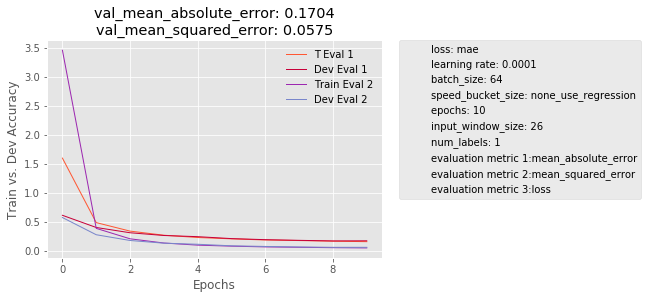

Found results file


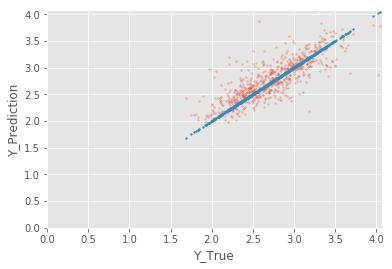

Successfully created plots and figures for model 20180926_004729
Starting to train model 20180926_004746: bs=64, lr=0.001, opt=adam, lf=mae, epochs=10
Train on 6635 samples, validate on 716 samples
Epoch 1/10
 - 3s - loss: 0.5988 - mean_squared_error: 0.8729 - mean_absolute_error: 0.5988 - val_loss: 0.2413 - val_mean_squared_error: 0.1053 - val_mean_absolute_error: 0.2413
Epoch 2/10
 - 1s - loss: 0.1944 - mean_squared_error: 0.0691 - mean_absolute_error: 0.1944 - val_loss: 0.1750 - val_mean_squared_error: 0.0582 - val_mean_absolute_error: 0.1750
Epoch 3/10
 - 1s - loss: 0.1624 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1624 - val_loss: 0.1611 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1611
Epoch 4/10
 - 1s - loss: 0.1502 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1502 - val_loss: 0.1519 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1519
Epoch 5/10
 - 1s - loss: 0.1348 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1348 - v

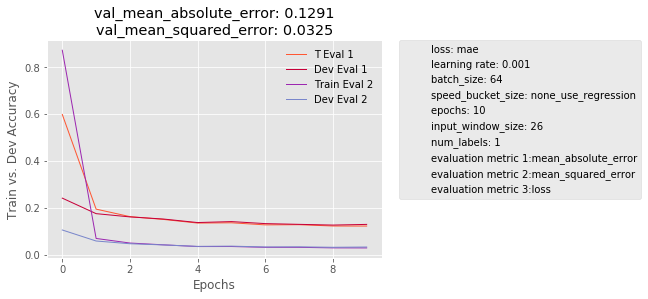

Found results file


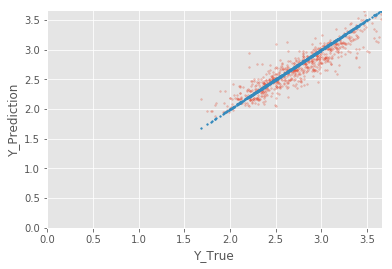

Successfully created plots and figures for model 20180926_004746
Completed all training runs!


In [62]:
for batch_size,learning_rate,optimizer_type,loss_function,training_epochs in itertools.product(batch_size_all,learning_rate_all,optimizer_type_all,loss_function_all,training_epochs_all):
    
    # Redefine model to reinitialize weights in each loop
    if  model_architecture == 'FCN':
        model = fcnModel()
    elif model_architecture == 'CNN':
        model = cnnModel_multInput()
    
    # Model run file naming conventions
    file_name = strftime("%Y%m%d_%H%M%S", gmtime()) # user input for filename of saved model
    print('Starting to train model ' + file_name + ': bs='+str(batch_size)+', lr='+str(learning_rate)+', opt='+optimizer_type+', lf='+loss_function+', epochs='+str(training_epochs))
    
    # If desired, load weights from a previous model to start with model
    if previous_model_weights_to_load != "":
        model.load_weights(folder_head_loc + "Model Final Parameters/" + previous_model_weights_to_load)
    
    # Define optimizer
    if optimizer_type == 'adam':
        model_optimizer = optimizers.Adam(lr = learning_rate) #, decay, beta_1, beta_2 are HPs
    elif optimizer_type == 'rmsprop':
        model_optimizer = optimizers.RMSprop(lr = learning_rate) #, decay, rho
    elif optimizer_type == 'gradient':
        model_optimizer = optimizers.SGD(lr = learning_rate) #, decay, momentum
    
    # Compile model with appropriate loss function
    if speed_bucket_size != 'none_use_regression': # if performing classification, ALWAYS use cross-entropy loss
        model.compile(loss ='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy',class_percent_2buckRange, class_mae, class_mse]) # class_percent_1buckLow,class_percent_1buckHigh,class_percent_2buckLow, class_percent_2buckHigh,'class_mape'
    else:                                          # if performing regression, use mean squared error or mean absolute error
        if loss_function == 'categorical_crossentropy': raise NameError('Are you sure you want to use cross entropy loss with a regression tasks!?')
        model.compile(loss = loss_function, optimizer=model_optimizer, metrics=['mse','mae']) # options: 'mse','mae', 'mape'

    # Train model
    start_time = time.time()
    if  model_architecture == 'FCN':
        history = model.fit(X_train, y_train, batch_size= batch_size, epochs=training_epochs, verbose=verbose_option, validation_data=(X_test, y_test))
    elif model_architecture == 'CNN':
        history = model.fit([X_train_timeseries, X_train_anthro], y_train, batch_size= batch_size, epochs=training_epochs, verbose=verbose_option, validation_data=([X_test_timeseries, X_test_anthro], y_test))
    end_time=time.time()
    
    print('Finished training model ' + file_name + '!')
    
        
    # Transform key results into a np arrary
    trainAccuracy_1 = np.squeeze(history.history[accuracy_reporting_metric_1])
    devAccuracy_1 = np.squeeze(history.history[dev_reporting_metric_1])
    trainAccuracy_2 = np.squeeze(history.history[accuracy_reporting_metric_2])
    devAccuracy_2 = np.squeeze(history.history[dev_reporting_metric_2])    
    trainAccuracy_3 = np.squeeze(history.history[accuracy_reporting_metric_3])
    devAccuracy_3 = np.squeeze(history.history[dev_reporting_metric_3])
    trainAccuracy_4 = np.squeeze(history.history[accuracy_reporting_metric_4])
    devAccuracy_4 = np.squeeze(history.history[dev_reporting_metric_4])
    epochs = np.squeeze(range(1,training_epochs + 1))
    # Declare final values for results
    final_accuracy_1 = history.history[accuracy_reporting_metric_1][training_epochs - 1]
    final_accuracy_dev_1 = history.history[dev_reporting_metric_1][training_epochs - 1]
    final_accuracy_2 = history.history[accuracy_reporting_metric_2][training_epochs - 1]
    final_accuracy_dev_2 = history.history[dev_reporting_metric_2][training_epochs - 1]
    final_accuracy_3 = history.history[accuracy_reporting_metric_3][training_epochs - 1]
    final_accuracy_dev_3 = history.history[dev_reporting_metric_3][training_epochs - 1]
    final_accuracy_4 = history.history[accuracy_reporting_metric_4][training_epochs - 1]
    final_accuracy_dev_4 = history.history[dev_reporting_metric_4][training_epochs - 1]
    # Save results to a .csv in the "Learning Curve Results"
    df_devAccuracy = pd.DataFrame(np.transpose(np.vstack([epochs,devAccuracy_1, devAccuracy_2, devAccuracy_3, devAccuracy_4])))
    filepath_acc = folder_head_loc + "Learning Curves/" + str(file_name) +"_AccuracyPerEpoch_Data" + ".csv"
    df_devAccuracy.to_csv(filepath_acc, header = ["Epochs", dev_reporting_metric_1, dev_reporting_metric_2, dev_reporting_metric_3, 'acc'], index=False)

    # Create a plot of Learning Curves
    create_learning_curves_from_model(machine_to_run_script
                ,trainAccuracy_4
                ,devAccuracy_4
                ,trainAccuracy_1
                ,devAccuracy_1
                ,trainAccuracy_2
                ,devAccuracy_2
                ,dev_reporting_metric_1
                ,final_accuracy_dev_1
                ,dev_reporting_metric_2
                ,final_accuracy_dev_2
                ,loss_function
                ,learning_rate
                ,batch_size
                ,speed_bucket_size
                ,training_epochs
                ,input_window_size
                ,labels_to_number
                ,accuracy_reporting_metric_1
                ,accuracy_reporting_metric_2
                ,accuracy_reporting_metric_3
                ,plot_note
                ,folder_head_loc
                ,file_name)

    # Add the results of the most recent run to the results file for documentation
    populate_results_performance_table(folder_head_loc,
                results_file_name,
                model_architecture,
                file_name,
                myFileLocation,
                training_epochs,  
                end_time,
                start_time,
                final_accuracy_1,
                final_accuracy_dev_1,
                final_accuracy_2,
                final_accuracy_dev_2,
                final_accuracy_3,
                final_accuracy_dev_3,
                batch_size,    
                learning_rate,
                speed_bucket_size,
                loss_function,
                input_window_size,
                label_window_size,
                optimizer_type,
                accuracy_reporting_metric_1,
                accuracy_reporting_metric_2,
                accuracy_reporting_metric_3,
                num_hidden_fc_layers,
                hidden_units_strategy,
                activations_strategy,
                dropout_rates,
                hidden_units_strategy_CNN,
                num_filters,
                kernel_size,
                sample_stride,
                activation_conv_layer,
                activations_strategy_CNN,
                max_pool_kernel_size)    
        
#     # Create confusion matrices
    if  model_architecture == 'FCN':
        y_pred = model.predict(X_test)
    elif model_architecture == 'CNN':
        y_pred = model.predict([X_test_timeseries, X_test_anthro])    
    create_conf_matrix_from_model(machine_to_run_script
            ,y_test
            ,y_pred
            ,folder_head_loc
            ,file_name
            ,speed_bucket_size)  

    print('Successfully created plots and figures for model ' + file_name)
    
    # Save model weights
    if machine_to_run_script == 'local':
        completed_model_name = file_name + "_" + model_architecture
        model.save_weights(folder_head_loc + "Model Final Parameters/" + completed_model_name + '_weights.h5')
        # THIS DOES NOT WORK IN SHERLOCK RIGHT NOW
        
print('Completed all training runs!')

### End of Script